<a href="https://colab.research.google.com/github/Ignacio-Ibarra/Approximate-String-Matching/blob/main/TFIDF_String_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Paquetes Básicos
import pandas as pd
import numpy as np
import random
import os
import time
import matplotlib.pyplot as plt
from functools import reduce
 
#NLP 
import nltk
import re
import string
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install sparse_dot_topn
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
 
#Montando Drive en la Session de Google Colab
from google.colab import drive 
drive.mount("/content/drive")
 
#Displaying options
pd.set_option("max_colwidth", 60)
 
#RUTA DATASET 
DIRTY_NAMES = '/content/drive/MyDrive/base importadores/outputs/sucios_a_first_cleaning/sucios_a_first_cleaning18_06_21.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TFIDF

In [ ]:
dirty_company_names = pd.read_csv(DIRTY_NAMES)
dirty_company_names = dirty_company_names[dirty_company_names.first_cleaning!="Se borró nombre en limpieza"].reset_index(drop=True)
first_cleaning = dirty_company_names.first_cleaning.unique().tolist()

In [ ]:
dirty_company_names[dirty_company_names.first_cleaning.str.contains("SUZHOU")]

,id,unicos_sucios,first_cleaning
1390,1390,(052448)SAMSUNG ELECTRONICS SUZHOU COMPUTER CO L,SAMSUNG ELECTRONICS SUZHOU COMPUTER CO L
3244,3250,(00020508)SUZHOU YINGHAN TEXTILE CO.'LTD.,SUZHOU YINGHAN TEXTILE CO LTD
3323,3329,(010744) SUZHOU PARSUN POWER MACHINE CO LTD,SUZHOU PARSUN POWER MACHINE CO LTD
4396,4413,R.16869 SUZHOU (CHINA) SUNSHINE HARDWARE& EQUIMENT,R SUZHOU SUNSHINE HARDWARE EQUIMENT
4818,4835,SUZHOU SUNMED CO.' LTD MV: 3715-17,SUZHOU SUNMED CO LTD MV
...,...,...,...
2300881,2309232,(140030)UOG OPTICS SUZHOU CO.'LTD,UOG OPTICS SUZHOU CO LTD
2301456,2309807,(064116)SUZHOU SAMSUNG ELECTRONICS CO. LTD.,SUZHOU SAMSUNG ELECTRONICS CO LTD
2302627,2310987,SUZHOU DOUBLE GOLD INDUSTRY CO. LTD -,SUZHOU DOUBLE GOLD INDUSTRY CO LTD
2303331,2311693,"(100155)SUZHOU QUANJUDA PURIFICATION TECH CO., LTD",SUZHOU QUANJUDA PURIFICATION TECH CO LTD


## n-gramas, common_words & odd_words



In [ ]:
from collections import Counter

def get_corpus_splitted(serie): 
  text = " ".join(serie)
  return re.findall(r'\b\S+\b', text)

def wordcount_df_from_serie(serie): 
  counter = Counter()
  text = get_corpus_splitted(serie)
  for word in text:
    counter[word] +=1
  return pd.DataFrame(counter.items(), columns=['word', 'counts']).sort_values(by="counts", ascending=False).reset_index(drop=True)

In [ ]:
word_count = wordcount_df_from_serie(first_cleaning)

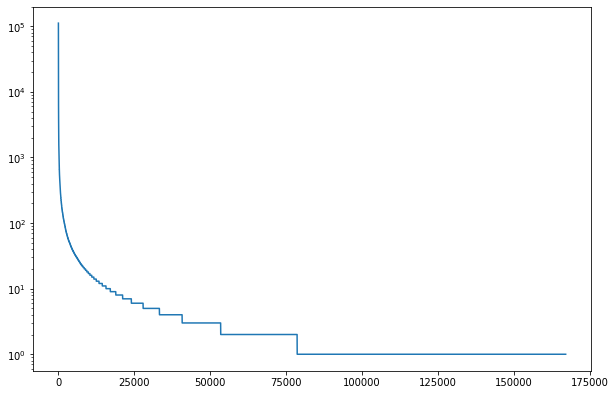

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6.7)
fig, ax = plt.subplots()

#graphic = word_count[word_count.length<3]
graphic = word_count

words = graphic.word.to_numpy()
x_pos = np.arange(len(words))
counts = graphic.counts

ax.plot(x_pos, counts)
plt.yscale('log')
plt.xscale('linear')
# ax.set_xticks(x_pos)
# ax.set_xticklabels(words, rotation=90)
#ax.invert_xaxis()  # labels read top-to-bottom
# ax.set_ylabel('Quantity')
# ax.set_title('Most Common Words')

plt.show()

In [ ]:
word_count['length'] = word_count.word.apply(lambda x: len(x))

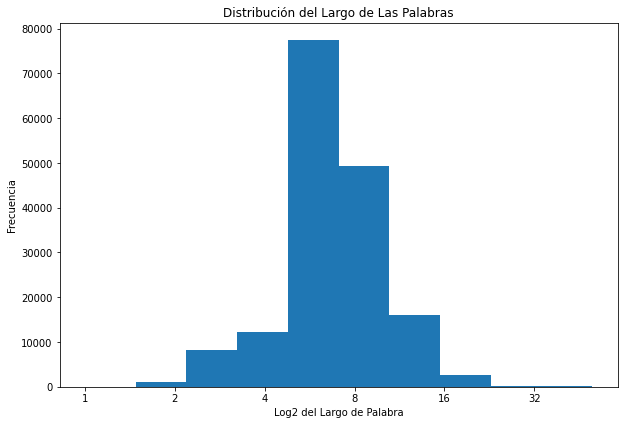

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6.7)
fig, ax = plt.subplots()

length = word_count.length.to_numpy()
counts = word_count.counts.to_numpy()

ax.hist(np.log2(length))

ax.set_xticklabels([0,1,2,4,8,16,32])
ax.set_xlabel("Log2 del Largo de Palabra")
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución del Largo de Las Palabras')

plt.show()

Sacamos las palabras menos comunes y cortas para que no influyan tanto

In [ ]:
dirty_company_names[dirty_company_names.unicos_sucios.str.contains("CATERPILLAR")]

,id,unicos_sucios,first_cleaning
145,145,CATERPILLAR' INC.,CATERPILLAR INC
1121,1121,(098961)CATERPILLAR AMERICAS C.V.-158010842 - MK,CATERPILLAR AMERICAS CV MK
1125,1125,(102010) CATERPILLAR AMERICAS C.V.SUDU250013028KVR,CATERPILLAR AMERICAS CVSUDUKVR
1126,1126,(102599)CATERPILLAR AMERICAS C.V.-158050594 - MK,CATERPILLAR AMERICAS CV MK
1133,1133,(108083)CATERPILLAR AMERICAS C.V.-158110233 NB,CATERPILLAR AMERICAS CV NB
...,...,...,...
2310372,2311131,CATERPILLAR AMERICAS CV ALX-208100333 (679417),CATERPILLAR AMERICAS CV ALX
2310484,2311243,(603859)CATERPILLAR AMERICAS C.V.-ALX-198120512,CATERPILLAR AMERICAS CV ALX
2311174,2311933,(609242)CATERPILLAR AMERICAS C.V.ALX-218011930,CATERPILLAR AMERICAS CVALX
2311175,2311934,(609565)CATERPILLAR AMERICAS C.V.-ALX-218030079,CATERPILLAR AMERICAS CV ALX


In [ ]:
len(semi_odd_words)

540

In [ ]:
semi_odd_words = word_count[(word_count.counts.between(10,900)) & (word_count.length.between(1,2))& (word_count.word.isin(["3M","LG"])==False)].set_index('word')['counts'].to_dict()



In [ ]:
semi_odd_words["HW"]

644

In [ ]:
def del_odd_words(text): 
  return " ".join([word for word in text.split(" ") if word not in semi_odd_words])

In [ ]:
del_odd_words("HUAWEI INTERNATIONAL CL GDL HW")

'HUAWEI INTERNATIONAL GDL'

In [ ]:
second_cleaning = dirty_company_names.copy()
second_cleaning['second_cleaning'] = second_cleaning.first_cleaning.apply(lambda x: del_odd_words(x))
second_cleaning.loc[second_cleaning.second_cleaning=="", "second_cleaning"]="Se borró nombre en limpieza"
second_cleaning

,id,unicos_sucios,first_cleaning,second_cleaning
0,0,TAKMAY INDUSTRIAL COMPANY LIMITED,TAKMAY INDUSTRIAL COMPANY LIMITED,TAKMAY INDUSTRIAL COMPANY LIMITED
1,1,TEAMBO INDUSTRY LIMITED,TEAMBO INDUSTRY LIMITED,TEAMBO INDUSTRY LIMITED
2,2,(768981)SMARTMAX ENTERPRISES LIMITED,SMARTMAX ENTERPRISES LIMITED,SMARTMAX ENTERPRISES LIMITED
3,3,MASCHIENENBAU HALDENWANG HMBH&CO.KG ABA 514,MASCHIENENBAU HALDENWANG HMBH&CO KG ABA,MASCHIENENBAU HALDENWANG HMBH&CO KG ABA
4,4,(070434)LONGINOTTI GROUP S.R.L,LONGINOTTI GROUP S R L,LONGINOTTI GROUP S R L
...,...,...,...,...
2303933,2312296,RENOBAT ENERGY SOLUTIONS,RENOBAT ENERGY SOLUTIONS,RENOBAT ENERGY SOLUTIONS
2303934,2312297,HEBEI MINGSHUAI FURNITURE SALES CO. LTD,HEBEI MINGSHUAI FURNITURE SALES CO LTD,HEBEI MINGSHUAI FURNITURE SALES CO LTD
2303935,2312298,DOMSJO FABRIKER AB / 18932,DOMSJO FABRIKER AB,DOMSJO FABRIKER AB
2303936,2312299,(20003447)PIRELLI TYRE S.P.A,PIRELLI TYRE S P A,PIRELLI TYRE S P A


In [ ]:
second_cleaning.to_csv("/content/drive/MyDrive/base importadores/outputs/first_a_second_cleaning/first_second18-06-21B.csv", index=False)

Vectorizo por n-gramas (n=3) y las palabras más comunes las vectorizo como palabras y no como N-gramas. 

In [ ]:
second_cleaning = pd.read_csv("/content/drive/MyDrive/base importadores/outputs/first_a_second_cleaning/first_second18-06-21B.csv")

In [ ]:
word_count = wordcount_df_from_serie(second_cleaning.second_cleaning.to_list())
TOPNCOMMON = 196 #la idea es armar una lista de palabras que no sean nombre propio 
                 #(sí va BRASIL, pero no HUAWEI, CATERPILLAR aunque se repitan mucho)
common_words = word_count.iloc[:TOPNCOMMON,:].word.to_list()

In [ ]:
common_words

['LTD',
 'CO',
 'S',
 'A',
 'LTDA',
 'INC',
 'BRASIL',
 'DE',
 'INTERNATIONAL',
 'GMBH',
 'I',
 'LIMITED',
 'SA',
 'E',
 'DO',
 'C',
 'COMPANY',
 'LLC',
 'CORPORATION',
 'AMERICA',
 'AG',
 'V',
 'L',
 'TRADING',
 'IND',
 'INDUSTRIAL',
 'AND',
 'GROUP',
 'OP',
 'INDUSTRIA',
 'PRODUCTS',
 'TECHNOLOGY',
 'P',
 'B',
 'R',
 'PO',
 'CORP',
 'COM',
 'LATIN',
 'ELECTRONICS',
 'EXPORT',
 'IMPORT',
 'SERVICES',
 'SPA',
 'M',
 'CHEMICAL',
 'INT',
 'SYSTEMS',
 'IMP',
 'COMERCIO',
 'AB',
 'SRL',
 'NINGBO',
 'AUTOMOVEIS',
 'OC',
 'AMERICAS',
 'USA',
 'LP',
 'TRADE',
 'PEUGEOT',
 'EXP',
 'CHILE',
 'INDUSTRIES',
 'CATERPILLAR',
 'CITROEN',
 'VOLKSWAGEN',
 'KG',
 'GLOBAL',
 'REF',
 'SIEMENS',
 'CV',
 'ZHEJIANG',
 'PNEUS',
 'BV',
 'SERVICE',
 'TECHNOLOGIES',
 'INDUSTRY',
 'MACHINERY',
 'EQUIPMENT',
 'DOW',
 'ENERGY',
 'O',
 'SHANGHAI',
 'THE',
 'SCANIA',
 'ABB',
 'DEERE',
 'PARTS',
 'URUGUAY',
 'DELL',
 'SOLUTIONS',
 'EUROPE',
 'CHEMICALS',
 'MEXICO',
 'AUTOMOBILES',
 'F',
 'PAK',
 'FCA',
 'TETRA',
 'SA

In [ ]:
common_words.remove("ABB")

In [ ]:
common_words.index("XIAMEN")

173

In [ ]:
def ngrams(string, n=3): 
    commons = []
    text = []
    for word in string.split(" "):
      if word not in common_words:
        text.append(word)
      else: 
        commons.append(word)
    text = " ".join(text)
    ngrams = zip(*[text[i:] for i in range(n)])
    lista = np.unique([''.join(ngram) for ngram in ngrams]+commons).tolist()
    return lista

def ngrams2(text, n=3): 
    ngrams = zip(*[text[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]  

## `TfidfVectorizer`

In [ ]:
second = second_cleaning.second_cleaning.unique()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(min_df=3, analyzer=ngrams2) 
tf_idf_second_cleaning = vectorizer.fit_transform(second)


In [ ]:
tf_idf_second_cleaning.shape

(493028, 14207)

## `awesome_cossim_topn`

In [ ]:
from scipy.sparse import csr_matrix
from sparse_dot_topn import awesome_cossim_topn

import time
t1 = time.time()
matches_ngrams = awesome_cossim_topn(tf_idf_second_cleaning, tf_idf_second_cleaning.transpose(), 200, 0.8)
t = time.time()-t1
print('This program remains {} seconds with ngrams'.format(t))

This program remains 2562.7749745845795 seconds with ngrams


In [ ]:
from scipy import sparse

"""
Guardo macheos en un archivo npz porque tarda mucho en correr 
el producto de matrices, porque son muy grandes. Dado que el resultado es determinístico 
no es necesario volver a correrlo nuevamente a menos que cambie 
algún parámetro de la limpieza, del vecotrizador o de la función awesome_cossim_topn
"""

ngrams_filename = '/content/drive/MyDrive/base importadores/outputs/TF-IDF_matches_save/ngrams_matces_csr_saving18_06_2021B.npz'
sparse.save_npz(ngrams_filename, matches_ngrams)

# Para cargar de nuevo la matriz descomentar la siguiente linea. 
#matches_ngrams = sparse.load_npz(ngrams_filename)

## Ejemplos de Similares

In [ ]:
second = list(second)

In [ ]:
second.index("HUAWEI")

1097

In [ ]:
print(matches_ngrams[second.index("HUAWEI"),:])

  (0, 1097)	1.0000000000000002
  (0, 76678)	0.9055067503799783
  (0, 436089)	0.8769072592601155
  (0, 60671)	0.8695081441751464
  (0, 59928)	0.860370567832566
  (0, 68182)	0.8536831019288952
  (0, 1163)	0.8526640428030399
  (0, 105352)	0.8523746846298268
  (0, 9013)	0.8510895504984742
  (0, 33137)	0.8481556866794108
  (0, 32231)	0.8478290088338228
  (0, 95333)	0.8456744597260242
  (0, 15616)	0.8454894280122578
  (0, 64137)	0.8444064096507742
  (0, 98308)	0.8436977781354564
  (0, 42912)	0.8420150794990177
  (0, 22586)	0.8342327156959349
  (0, 346208)	0.8316311960860362
  (0, 38083)	0.8313517591123646
  (0, 119271)	0.8308781888371056
  (0, 9018)	0.8275081666152271
  (0, 55686)	0.8269960462934765
  (0, 1081)	0.8266476330689683
  (0, 1082)	0.8127141700966009


In [ ]:
for i in matches_ngrams[second.index("HUAWEI"),:].indices: 
  print(second[i])

HUAWEI
HUAWEIR
HUAWEIC
HUAWEI S
HUAWEI C
HUAWEI T
HUAWEI E
HUAWEI A
HUAWEI M
HUAWEI L
HUAWEI P
HUAWEI G
HUAWEI F
HUAWEI H
HUAWEI D
HUAWEI B
HUAWEI R
HUAWEI INT
HUAWEI J
HUAWEI V
HUAWEI N
HUAWEI K
HUAWEI Y
HUAWEI U


In [ ]:
print("YA CORRIO TODOOOO")

YA CORRIO TODOOOO


## Obtengo similares

In [ ]:
from tqdm import tqdm

massive_dict = {}
for key in tqdm(range(matches_ngrams.shape[0])):
  massive_dict[key] = matches_ngrams[key,:].indices

ya_vistos = {}
grupos = []
for i in tqdm(range(matches_ngrams.shape[0])): 
  if i not in ya_vistos:
    ya_vistos[i]=1
    unicos = massive_dict[i].tolist()
    if len(unicos)>1:
      indices = massive_dict[i][1:]
      for ind in indices:
        if ind not in ya_vistos:
          ya_vistos[ind]=1
          unicos = unicos + massive_dict[ind].tolist()
      unicos = list(set(unicos))
      grupos.append(unicos)
    else: 
      ya_vistos[i]=1
      grupos.append(unicos)

100%|██████████| 493028/493028 [00:02<00:00, 168223.30it/s]


In [ ]:
third_cleaning_tfidf = pd.DataFrame(second, columns = ['unicos_second_cleaning'])

from tqdm import tqdm
import functools

third_cleaning_tfidf['tfidf_cleaning'] = "no name"
for group in tqdm(grupos): 
  names = third_cleaning_tfidf.iloc[np.array(group, dtype="int64")]['unicos_second_cleaning'].to_list()
  if len(names)>1:
    group_name = functools.reduce(lambda a,b: b if len(a.split(" "))>len(b.split(" ")) else a, names).lstrip().rstrip()
  elif names == []:
    pass
  else:
    group_name = names[0].lstrip().rstrip() 
  third_cleaning_tfidf.iloc[np.array(group, dtype="int64"),1] = group_name

100%|██████████| 278651/278651 [02:01<00:00, 2292.06it/s]


In [ ]:
third_cleaning_tfidf

,unicos_second_cleaning,tfidf_cleaning
0,TAKMAY INDUSTRIAL COMPANY LIMITED,TAKMAY INDUSTRIAL COMPANY
1,TEAMBO INDUSTRY LIMITED,TEAMBO INDUSTRY LIMITED
2,SMARTMAX ENTERPRISES LIMITED,SMARMAX ENTERPRISES LIMITED
3,MASCHIENENBAU HALDENWANG HMBH&CO KG ABA,MASCHIENENBAU HALDENWANG HMBH&CO KG ABA
4,LONGINOTTI GROUP S R L,LONGINOTTI GROUP S R L
...,...,...
493023,WHEIHAI ADOLFO MACHINERY I&E CO LTD,WEIHAI ADOLFO MACHINERY I
493024,GUANGZHOU MAGI WAP CULTURE ARTICLES CO LTD,GUANGZHOU MAGI WAP CULTURE ARTICLES CO LTD
493025,GREAT LUCK TRADING LIMITED,GREAT LUCK TRADING LIMITED
493026,LAMINATE PACKAGING COLOMBIA SAS,LAMINATE PACKAGING COLOMBIA SAS


In [ ]:
third_cleaning_tfidf.to_csv("/content/drive/MyDrive/base importadores/outputs/tfidf_cleaning/tfidf_cleaning18_06_2021B.csv", index=False)